






                                                                        Brady Gehrman
                                                                      CSE 625 Project 3
                                                                  Date Submitted: 7/14/2023












In [9]:
using Base.Threads
using Statistics

In [10]:
# get the number of threads
nthreads()

4

In [219]:
"""
Implement the C function in a Julia function with the following specification:

sinx implements sin function with the Taylor series.
Arguments:
x angle
n number of terms used
degree x in degree if degree is true else in radians
"""

function sinx(x, n = 5; degree = true)
    if degree
        x = deg2rad(x)
    end
    terms = map(i -> ((-1)^(i-1) * x^(2i-1)) / factorial(2 * big(i) -1), 1:n)
    result = reduce(+, terms)
    return result
end

function sinx_Sequential(x, n = 5; degree = true)
    if degree
        x = deg2rad(x)
    end
    result = x
    for i in 1:n-1
        sign = i % 2 == 1 ? -1 : 1
        result += (sign * x^(2i+1)) / factorial(2*big(i) + 1)
    end
    return result
end

function sinx_Simd(x, n = 5; degree = true)
    if degree
        x = deg2rad(x)
    end  
    result = x
    @simd for i in 1:n-1
        sign = i % 2 == 1 ? -1 : 1
        result += (sign * x^(2i+1)) / factorial(2*big(i) + 1)
    end
    return result
end

function sinx_Threads(x, n = 5; degree = true)

    if degree
        x = deg2rad(x)
    end
    result = zero(BigFloat)
    partialSum = zeros(BigFloat, nthreads())
    result = x
    @threads for i in 1:n-1
        sign = i % 2 == 1 ? -1 : 1
        partialSum[threadid()] += (sign * x^(2i+1)) / factorial(2*big(i) + 1)
    end

    for i in 1:nthreads()
        result += partialSum[i]
    end

    return result
end

function sinx_ThreadsAndSimd(x, n = 5; degree = true)
    if degree
        x = deg2rad(x)
    end
    result = zero(BigFloat)
    partialSum = zeros(BigFloat, nthreads())
    result = x
    @threads for i in 1:n-1
        sign = i % 2 == 1 ? -1 : 1
        partialSum[threadid()] += (sign * x^(2i+1)) / factorial(2*big(i) + 1)
    end

    @simd for i in 1:nthreads()
        result += partialSum[i]
    end

    return result
end

sinx_ThreadsAndSimd (generic function with 2 methods)

In [223]:
# Sequential Sinx
@time [sinx_Sequential(i, 100) for i in 0:0.00_01:90]

284.357163 seconds (2.02 G allocations: 61.520 GiB, 28.90% gc time, 0.07% compilation time)


900001-element Vector{BigFloat}:
 0.0
 1.745329251993443506508015057682056655131399011055787928837053109746404048490373e-06
 3.490658503981570436081826375896493061269466611394853599369445679311524116337961e-06
 5.235987755959064000029009600928732692973661569708837575757837115436498821273482e-06
 6.981317007920608256690120007368891736966734751181406951843234172440203123326656e-06
 8.726646259860886205614577404024698367115746462171112995609937045002304569930217e-06
 1.047197551177458042283539280273542907633046063146737950897206649900094413053213e-05
 1.221730476365637517845155264662597009642322453316181935158163848078076394100051e-05
 1.396263401550095558959508754148477758530197749724102793696080697559252277552002e-05
 1.570796326730299999713456436200626292789069383766729275794794479813827800152842e-05
 ⋮
 0.9999999999025224237147173141477117917761772260173447745896993186480756087477767
 0.9999999999253687314829142227864030078525012884255971975701702106602284650465734
 0.9999999999451688

In [224]:
# Sequential with @simd Sinx
@time [sinx_Simd(i, 100) for i in 0:0.00_01:90]

278.867124 seconds (2.02 G allocations: 61.521 GiB, 28.99% gc time, 0.08% compilation time)


900001-element Vector{BigFloat}:
 0.0
 1.745329251993443506508015057682056655131399011055787928837053109746404048490373e-06
 3.490658503981570436081826375896493061269466611394853599369445679311524116337961e-06
 5.235987755959064000029009600928732692973661569708837575757837115436498821273482e-06
 6.981317007920608256690120007368891736966734751181406951843234172440203123326656e-06
 8.726646259860886205614577404024698367115746462171112995609937045002304569930217e-06
 1.047197551177458042283539280273542907633046063146737950897206649900094413053213e-05
 1.221730476365637517845155264662597009642322453316181935158163848078076394100051e-05
 1.396263401550095558959508754148477758530197749724102793696080697559252277552002e-05
 1.570796326730299999713456436200626292789069383766729275794794479813827800152842e-05
 ⋮
 0.9999999999025224237147173141477117917761772260173447745896993186480756087477767
 0.9999999999253687314829142227864030078525012884255971975701702106602284650465734
 0.9999999999451688

In [222]:
# @threads Sinx
@time [sinx_Threads(i, 100) for i in 0:0.00_01:90]

230.529142 seconds (2.24 G allocations: 67.202 GiB, 29.97% gc time, 0.03% compilation time)


900001-element Vector{BigFloat}:
 0.0
 1.745329251993443506508015057682056655131399011055787928837053109746404048490373e-06
 3.490658503981570436081826375896493061269466611394853599369445679311524116337928e-06
 5.235987755959064000029009600928732692973661569708837575757837115436498821273416e-06
 6.981317007920608256690120007368891736966734751181406951843234172440203123326656e-06
 8.726646259860886205614577404024698367115746462171112995609937045002304569930086e-06
 1.0471975511774580422835392802735429076330460631467379508972066499000944130532e-05
 1.221730476365637517845155264662597009642322453316181935158163848078076394100051e-05
 1.396263401550095558959508754148477758530197749724102793696080697559252277552002e-05
 1.570796326730299999713456436200626292789069383766729275794794479813827800152816e-05
 ⋮
 0.999999999902522423714717314147711791776177226017344774589699318648075608747794
 0.9999999999253687314829142227864030078525012884255971975701702106602284650465561
 0.9999999999451688504

In [221]:
# @threads with @simd Sinx
@time [sinx_ThreadsAndSimd(i, 100) for i in 0:0.00_01:90]

207.663278 seconds (2.24 G allocations: 67.207 GiB, 28.14% gc time, 0.28% compilation time)


900001-element Vector{BigFloat}:
 0.0
 1.745329251993443506508015057682056655131399011055787928837053109746404048490373e-06
 3.490658503981570436081826375896493061269466611394853599369445679311524116337928e-06
 5.235987755959064000029009600928732692973661569708837575757837115436498821273416e-06
 6.981317007920608256690120007368891736966734751181406951843234172440203123326656e-06
 8.726646259860886205614577404024698367115746462171112995609937045002304569930086e-06
 1.0471975511774580422835392802735429076330460631467379508972066499000944130532e-05
 1.221730476365637517845155264662597009642322453316181935158163848078076394100051e-05
 1.396263401550095558959508754148477758530197749724102793696080697559252277552002e-05
 1.570796326730299999713456436200626292789069383766729275794794479813827800152816e-05
 ⋮
 0.999999999902522423714717314147711791776177226017344774589699318648075608747794
 0.9999999999253687314829142227864030078525012884255971975701702106602284650465474
 0.9999999999451688504

*note: I chose to use a smaller number of computations because of runtime contraints for problem 1 (n=100, interval is 0.0001) 

Runtimes of these four implementations:

Sequential: 284.357163 seconds
Sequential with @simd: 278.867124 seconds
@threads: 220.785671 seconds
@threads with @simd: 207.663278 seconds

Speed-up and efficiency of the parallel computing versions:

@threads: 
1.29 speedup from sequential yeilding 32.25% efficiency, 1.26 speedup from sequential with @simd yeilding 31.5% efficency

@threads with @simd:
1.37 speedup from sequential yeilding 34.3% efficiency, 1.34 speedup from sequential with @simd yeilding 33.6% efficency



2. This problem is to perform load balancing analysis of multi-threaded Mandelbrot set computation

In [54]:
function setMandelbrotPixel(c, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
    abs2(z)> 4.0 && return (i-1)%UInt8
    z = z*z + c
    end
    return niter%UInt8
end

function MandelbrotSet(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    return pic
end
   

MandelbrotSet (generic function with 8 methods)

In [55]:
"""
Use @threads to parallelize the Mandelbrot set computing
"""

function MandelbrotSet_Threads(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    return pic
end


MandelbrotSet_Threads (generic function with 8 methods)

In [56]:
using BenchmarkTools
using ColorSchemes
using Plots
gr()

Plots.GRBackend()

In [139]:
# Use @btime to measure the runtime of the sequential Mandelbrot function
mandel = @btime MandelbrotSet()


  44.672 ms (2 allocations: 468.86 KiB)


600×800 Matrix{UInt8}:
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
    ⋮                             ⋮  ⋱           ⋮                    
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00 

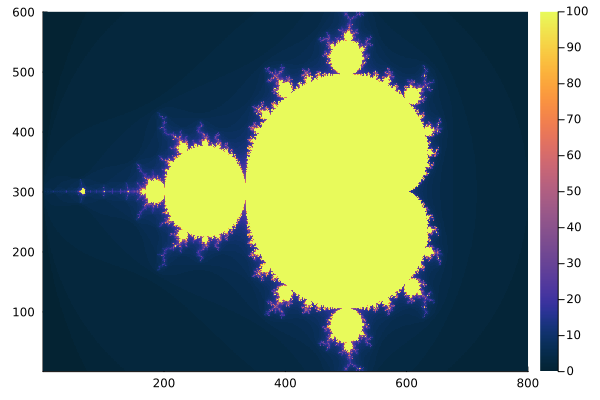

In [58]:
heatmap(1:size(mandel,2),1:size(mandel,1), mandel, color = :thermal)

In [140]:
# Use @btime to measure the runtime of the threaded Mandelbrot function
mandel_Threads = @btime MandelbrotSet_Threads()


  26.333 ms (27 allocations: 471.73 KiB)


600×800 Matrix{UInt8}:
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
    ⋮                             ⋮  ⋱           ⋮                    
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00 

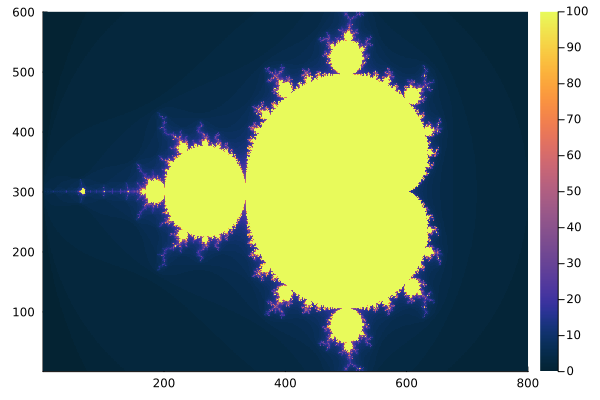

In [60]:
heatmap(1:size(mandel_Threads,2),1:size(mandel_Threads,1), mandel_Threads, color = :thermal)

In [61]:
mandel_Threads == mandel

true

2.1:

MandelbrotSet Runtime: 44.253 ms

MandelbrotSet_Threads Runtime: 26.561 ms

efficiency of the parallel computing function (threaded): = (44.253 ms / 26.561 ms)/ 4 threads * 100 = 41.65%

In [74]:
"""
Insert code into the threaded function to count, for each thread, the total number of iterations required to compute the pixel values.
"""

function setMandelbrotPixel_Bar(c, interPerThread, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
    if(abs2(z)> 4.0)
        interPerThread[threadid()] += i
        return (i-1)%UInt8
    end
    z = z*z + c
    end
    interPerThread[threadid()] += niter
    return niter%UInt8
end

function MandelbrotSet_Threads_Bar(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    interPerThread = zeros(Integer, nthreads())
    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel_Bar(x+y*im, interPerThread, niter)
        end
    end

    # Plot the resulting count in a Bar chart
    x = ["Thread 1", "Thread 2", "Thread 3", "Thread 4"]
    y = interPerThread
    bar(x, y, title = "Iterations Per Thread", xlabel = "Thread #", ylabel = "Iterations", legend = false)
    plot!() 
    
    # return pic
end

MandelbrotSet_Threads_Bar (generic function with 8 methods)

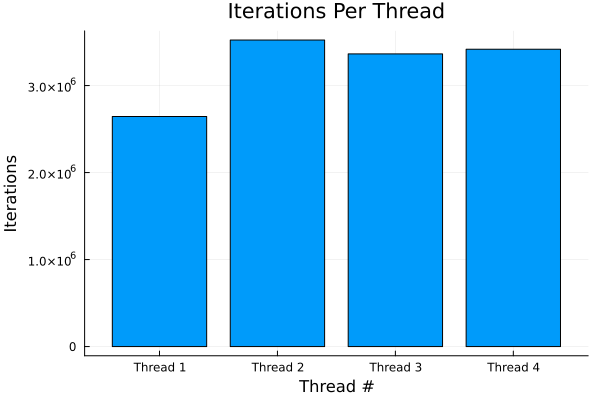

In [108]:
MandelbrotSet_Threads_Bar()

2.2: From the Bar chart, you can see that each thread is not load balanced, meaning that each thread had to run a different number of iterations, in this case it is quite drastic. This is an issue because in an ideal world we want each thread to do an equal amount of work so that the function has a faster runtime. In this case the @threads code is using static scheduling instead of dynamic.

In [135]:
"""
Modify the threaded function to fix the problem as demonstrated in the Bar chart in problem 2.2 (Load balancing)
"""

function setMandelbrotPixel_Threads_LoadBal(c, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
    abs2(z)> 4.0 && return (i-1)%UInt8
    z = z*z + c
    end
    return niter%UInt8
end

function MandelbrotSet_Threads_LoadBal(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    @sync for j in 1:width
        x = x_start+(j-1)*dx
        @spawn for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel_Threads_LoadBal(x+y*im, niter)
        end
    end
    return pic
end


MandelbrotSet_Threads_LoadBal (generic function with 8 methods)

In [141]:
mandel_Threads_LoadBal = @btime MandelbrotSet_Threads_LoadBal()

  12.607 ms (4021 allocations: 991.19 KiB)


600×800 Matrix{UInt8}:
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
    ⋮                             ⋮  ⋱           ⋮                    
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00 

2.3:

MandelbrotSet Runtime: 44.253 ms

MandelbrotSet_Threads Runtime: 26.561 ms

MandelbrotSet_Threads_LoadBal Runtime: 12.539 ms

efficiency of the modified threaded function compared to sequential: 88.23%

efficiency of the modified threaded function compared to static scheduled threads: 52.96%

In [137]:
mandel_Threads_LoadBal == mandel

true

In [146]:
"""
Insert code into the modified threaded function to count, for each thread, the total number of iterations required to compute the pixel values
"""

function setMandelbrotPixel_LoadBal_Bar(c, interPerThread, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
    if(abs2(z)> 4.0)
        interPerThread[threadid()] += i
        return (i-1)%UInt8
    end
    z = z*z + c
    end
    interPerThread[threadid()] += niter
    return niter%UInt8
end

function MandelbrotSet_Threads_LoadBal_Bar(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    interPerThread = zeros(Integer, nthreads())
    # Compute pic column by column
    @sync for j in 1:width
        x = x_start+(j-1)*dx
        @spawn for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel_LoadBal_Bar(x+y*im, interPerThread, niter)
        end
    end

    # Plot the resulting count in a Bar chart
    x = ["Thread 1", "Thread 2", "Thread 3", "Thread 4"]
    y = interPerThread
    bar(x, y, title = "Iterations Per Thread (Load Balanced)", xlabel = "Thread #", ylabel = "Iterations", legend = false)
    plot!() 
    
    # return pic
end

MandelbrotSet_Threads_LoadBal_Bar (generic function with 8 methods)

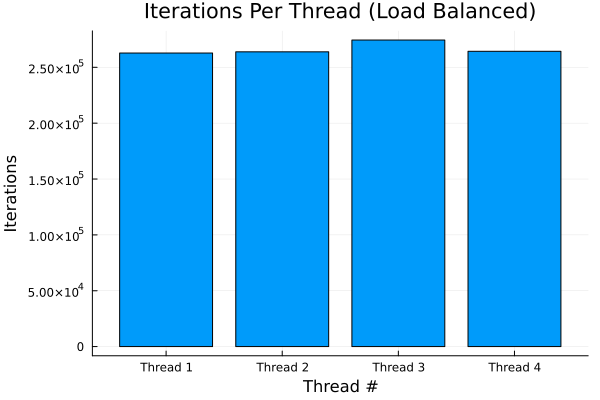

In [163]:
MandelbrotSet_Threads_LoadBal_Bar()

In [164]:
using Random

In [186]:
"""
Insert code into the modified threaded function (in problem 2.3) to set the pixel value to the thread ID of the thread which is assigned to compute it.
Plot the heatmap of the resulting picture with a colorscheme that assigns a distinct color to each thread ID.
"""

function setMandelbrotPixel_Threads_LoadBal_Heatmap(c, colorsPerThread, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
    abs2(z)> 4.0 && return colorsPerThread[threadid()]%UInt8
    z = z*z + c
    end
    return colorsPerThread[threadid()]%UInt8
end

function MandelbrotSet_Threads_LoadBal_Heatmap(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);

    # colorsPerThread = rand(1:255, nthreads())
    colorsPerThread = [0, 100, 175, 255]
   
    # Compute pic column by column
    @sync for j in 1:width
        x = x_start+(j-1)*dx
        @spawn for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel_Threads_LoadBal_Heatmap(x+y*im, colorsPerThread, niter)
        end
    end
    return pic
end


MandelbrotSet_Threads_LoadBal_Heatmap (generic function with 8 methods)

In [187]:
mandel_threads_loadbal = MandelbrotSet_Threads_LoadBal_Heatmap()

600×800 Matrix{UInt8}:
 0xaf  0x00  0xaf  0x64  0xaf  0xff  …  0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff  …  0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
    ⋮                             ⋮  ⋱           ⋮                    
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf  0x00  0xaf  0x64  0xaf  0xff     0xff  0xaf  0xff  0xaf  0xff  0xaf
 0xaf 

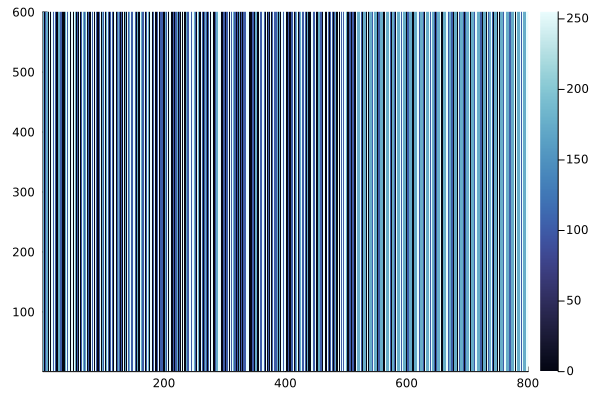

In [188]:
heatmap(mandel_threads_loadbal, color = :ice)

In [232]:
using Folds

In [233]:
"""
We want to compute the sum reduction of 10,000,000 random numbers.
Create functions for the following four implementations:
• Sequential
• @threads with partial sums
• Base.sum function
• Folds the Base.sum function (Folds is defined in the Folds package)
"""

function sum_sequential(array)
    r = zero(eltype(array))
    for i in eachindex(array)
        @inbounds r += array[i]
    end
    return r
end

function sum_threads_p(array)
    r = zero(eltype(array))
    partialSum = zeros(eltype(array), nthreads())
    @threads for i in eachindex(array)
        @inbounds  partialSum[threadid()] += array[i]
    end
    
    @simd for i in 1:nthreads()
        @inbounds r += partialSum[i]
    end
    return r
end

sum_threads_p (generic function with 1 method)

In [234]:
a = rand(10_000_000);


In [235]:
#Use @btime to measure the runtime of Sequential sum function
sumSeq = @btime sum_sequential(a)

  12.783 ms (1 allocation

: 16 bytes)


4.997576848825054e6

In [236]:
#Use @btime to measure the runtime of Multi-threaded sum function
sumMultiThread = @btime sum_threads_p(a)

  7.098 ms (27 allocations: 2.80 KiB)


4.997576848824848e6

In [239]:
#Use @btime to measure the runtime of Julia's sum function
sumJulia = @btime sum(a)

  6.156 ms (1 allocation: 16 bytes)


4.997576848825119e6

In [238]:
#Use @btime to measure the runtime of Folds the Base.sum function
sumFolds = @btime Folds.sum(a)

  6.490 ms (25 allocations: 2.08 KiB)


4.99757684882511e6

Discussion of the timing results: Listed fastest to slowest: Base.sum, Folds.sum, multithreaded_sum, sequential_sum

Julia's bulit in sum function and the Folds's package sum function were both fatser than my multithreaded_sum function, but not drastically.